# Exercise Session 5: Domain Adaptation
This week's exercise will focus on domain adaptation. For a more intuitive understanding of this topic, we will first demonstrate to you a representative method with the MNIST dataset for the image classification task. 

In the assignment, you will work on your own to implement other methods. Then you will be given another industrial audio dataset on which you choose your own method to get the optimal performance on it.

# Recap: Unsupervised Domain Adaptation (UDA)

Domain Adaptation is a technique to improve the performance of a model on a target domain containing insufficient annotated data by using the knowledge learned by the model from another related domain with adequate labeled data. The mechanism of domain adaptation is to uncover the common latent factors across the source and target domains and adapt them to reduce the difference in terms of the feature space between domains. 
<div>
    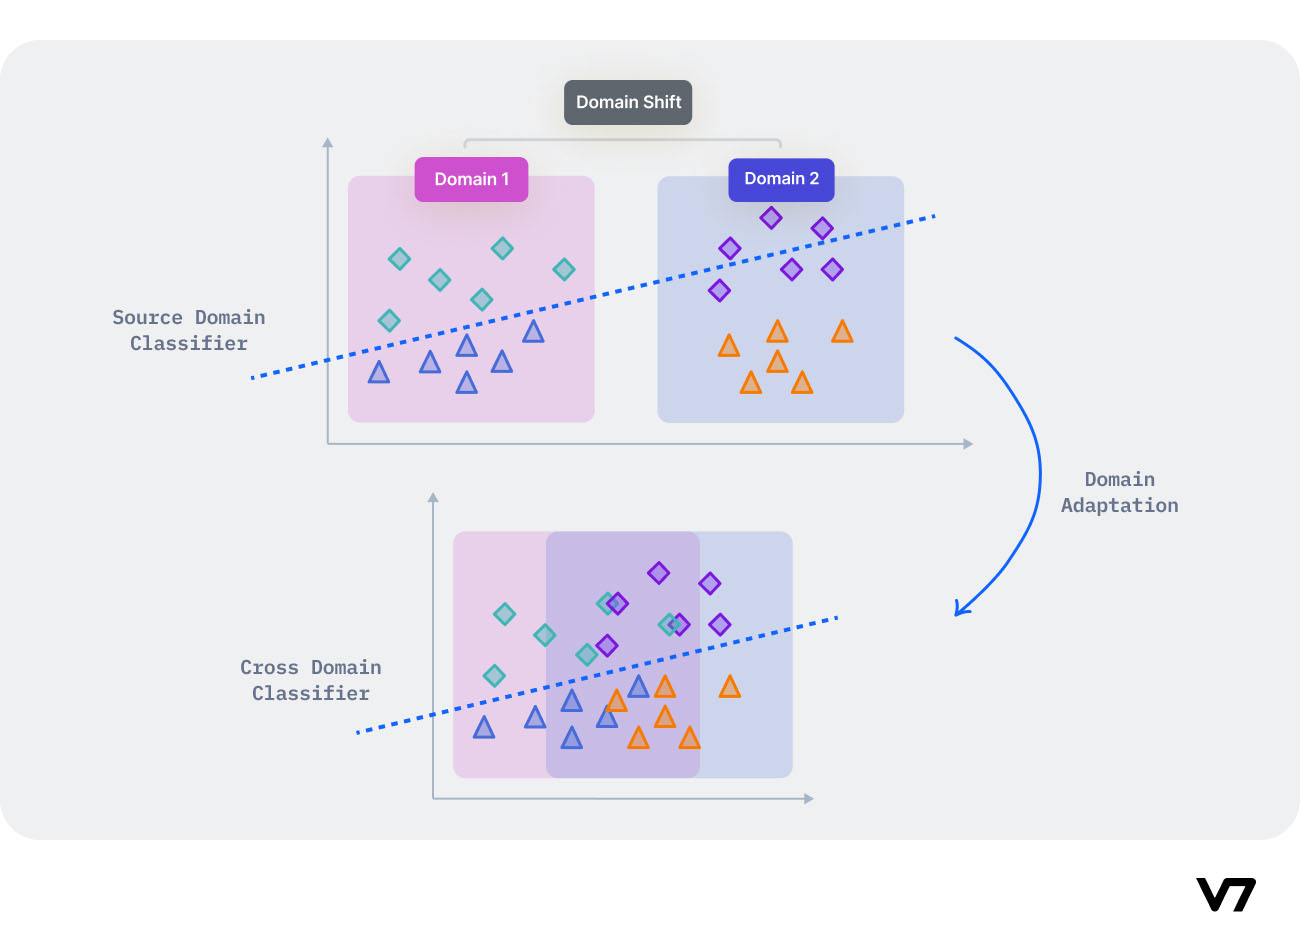
</div>

- Labeled training data from a source domain:
\begin{equation}
\mathcal{D}_s=\left\{\left(\mathbf{x}_s^1, \mathbf{y}_s^1\right), \ldots,\left(\mathbf{x}_s^m, \mathbf{y}_s^m\right)\right\}, \mathbf{y}_s^i \in Y
\end{equation}
- Unlabeld date from a target domain:
\begin{equation}
\mathcal{D}_t=\left\{\mathrm{x}_t^1, \ldots, \mathrm{x}_t^n\right\}
\end{equation}
- Test data from the same target domain:
\begin{equation}
\mathcal{D}_{\text {test }}=\left\{\mathbf{x}_{\text {test }}^1, \ldots, \mathbf{x}_{\text {test }}^o\right\}
\end{equation}

# MNIST Dataset

The MNIST database is a large database of handwritten digits, which is commonly used for the image classification task. The goal here is to classify the digit in each image. For our exercise, we take MNIST and its colorful variation MNIST-M to train the domain adaptation task:
- Source domain: MNIST
- Target domain: MNIST-M, a colored and textured version of MNIST

<div>
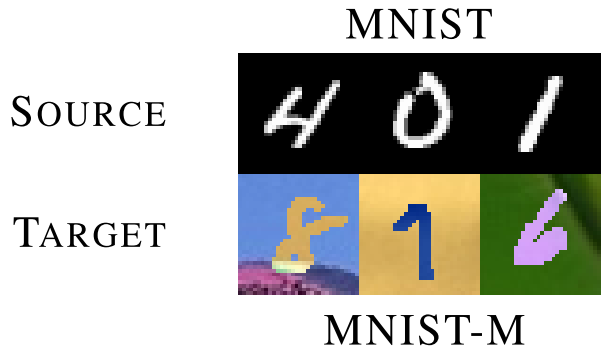
</div>

## Prepare Dataset

Download the file via this link:
[mnist dataset](https://drive.google.com/file/d/1Jlp9FcmF5yjk_XpvK5yDnQQm96-30FVC/view?usp=share_link)

In [ ]:
# setup
%matplotlib inline

import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
import torchvision as tv
import torchvision.transforms as tvtf
import torch.optim as optim
import torch.nn.functional as F
from utils.utils import test

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
# set parameters
image_size = 28
batch_size = 4

# import source & target dataset
from utils.data import MNISTMDataset

tf_source = tvtf.Compose([
    tvtf.Resize(image_size),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=(0.1307,), std=(0.3081,))
])
tf_target = tvtf.Compose([
    tvtf.Resize(image_size),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


#train dataLoader
ds_source = tv.datasets.MNIST(root = 'mnist_dataset/', train=True, transform=tf_source, download=True)
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)

ds_target = MNISTMDataset(os.path.join('mnist_dataset/mnist_m', 'mnist_m_train'),
                          os.path.join('mnist_dataset/mnist_m', 'mnist_m_train_labels.txt'),
                         transform=tf_target)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

#test dataLoader
ds_test_source = tv.datasets.MNIST(root = 'mnist_dataset/', train=False, transform=tf_source, download=True)
dl_test_source = torch.utils.data.DataLoader(ds_test_source, batch_size)

ds_test_target = MNISTMDataset(os.path.join('mnist_dataset/mnist_m', 'mnist_m_test'),
                          os.path.join('mnist_dataset/mnist_m', 'mnist_m_test_labels.txt'),
                         transform=tf_target)
dl_test_target = torch.utils.data.DataLoader(ds_test_target, batch_size)

In [ ]:
# check example data from MNIST & MNIST-M
from utils.utils import dataset_first_n

dataset_first_n(ds_source, 3, cmap='gray');
dataset_first_n(ds_target, 3);

## Baseline Network, without domain adaptation

In [ ]:
# define CNN model

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50), nn.Dropout2d(), nn.MaxPool2d(2),
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), nn.Dropout2d(),
            nn.ReLU(True),
            nn.Linear(100, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)

        # feature extractor
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        
        # classification head
        class_pred = self.class_classifier(features)

        return class_pred,features

In [ ]:
# set training parameters
lr = 1e-3
n_epochs = 2
batch_size = 64

In [ ]:
# model, optimizer & loss function
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr)
loss_fn_class = torch.nn.NLLLoss()

In [ ]:
# dataloader
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_test_source = torch.utils.data.DataLoader(ds_test_source, batch_size)
dl_test_target = torch.utils.data.DataLoader(ds_test_target, batch_size)

In [ ]:
# training
training_loss = 0
for epoch_idx in range(n_epochs):
    model.train()
    print(f'Epoch {epoch_idx+1:04d} / {n_epochs:04d}', end='\n=================\n')
    dl_source_iter = iter(dl_source)
    
    for batch_idx in tqdm(range(len(dl_source))):
        optimizer.zero_grad()
        # Train on source domain
        X_s, y_s = next(dl_source_iter)
        
        class_pred,_ = model(X_s.to(device))
        
        loss = loss_fn_class(class_pred, y_s.to(device))
        training_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    print(f'[{epoch_idx+1}/{n_epochs}] '
          f'class_loss: {training_loss/len(dl_source):.4f} ')
    training_loss = 0
    model.eval()
    print('Accuracy on SOURCE test dataset:', end=" ")
    test(model,dl_test_source)
    print('Accuracy on TARGET test dataset:', end=" ")
    test(model,dl_test_target)

Here we could see a large performance drop on the target MINIST-M dataset with a different distribution.

Now let's go for 3 main research branches in domain adaptation field. Each method forces the model to learn invariant features of the source & target domain by adding the constraint in different ways.

## Adversarial-based Method

### Recap: Adversarial Domain Adaptation
<div>
   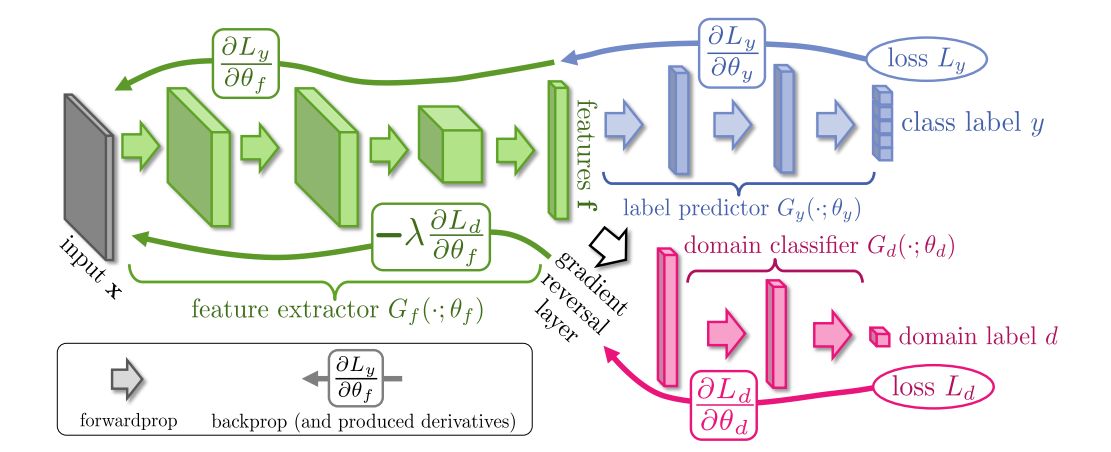
</div>
<font size="1"><i><center>Ganin, Yaroslav, and Victor Lempitsky. "Unsupervised domain adaptation by backpropagation." International conference on machine learning. PMLR, 2015.</center></i></font>

In addition to the base model on the classification task, we have a domain discriminator that discriminates between the source and target data. The training goal here is to train a model that can fool the domain discriminator. In this way, we encourage the model to generate similar features for source and target domains.

First, we define Gradient Reverse Layer(GRL) Layer, which is required for backpropogate the reverse gradient of the domain discriminator. [more information on GRL](https://arxiv.org/pdf/1409.7495.pdf)

In [ ]:
from torch.autograd import Function

# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # store context for backprop
        ctx.alpha = alpha
        # forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None

Next step is to defne the network with 3 components: feature extractor, common classifier and domain classifier. The first two are like what we did for the baseline model. A discriminator is defined to classify the source and the target. 

In [ ]:
class DANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50), nn.Dropout2d(), nn.MaxPool2d(2),
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), nn.Dropout2d(),
            nn.ReLU(True),
            nn.Linear(100, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )
        # domain classifier
        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            # TODO last two layers to classify source and target
            # .... your code here...

        )

    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        
        class_pred = self.class_classifier(features)
        domain_pred = self.domain_classifier(reverse_features)
        return class_pred, domain_pred

A common trick here: in order to help stablize the training process of the adversarial network, we introduce a learning rate scheduler, which reduces the learning rate as the training proceed.

In [ ]:
def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    :param optimizer: optimizer for updating parameters
    :param p: a variable for adjusting learning rate
    :return: optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75

    return optimizer

In [ ]:
lr = 1e-2
n_epochs = 5

# Setup optimizer as usual
model = DANN().to(device)
optimizer = optim.SGD(model.parameters(), lr, momentum = 0.9)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

# We'll train the same number of batches from both datasets
max_batches = min(len(dl_source), len(dl_target))

In [ ]:
# training
training_loss = 0
training_loss_domain = 0
training_loss_class = 0
p = 0

for epoch_idx in range(n_epochs):
    print(f'Epoch {epoch_idx+1:04d} / {n_epochs:04d}', end='\n=================\n')
    dl_source_iter = iter(dl_source)
    dl_target_iter = iter(dl_target)

    for batch_idx in tqdm(range(max_batches)):
        model.train()
        optimizer = optimizer_scheduler(optimizer=optimizer, p=p)
        optimizer.zero_grad()
        # Training progress and GRL lambda
        p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1

        # Train on source domain
        X_s, y_s = next(dl_source_iter)
        # Train on target domain
        X_t, _ = next(dl_target_iter) # ignore target domain class labels!
        batch_size = min(X_s.shape[0],X_t.shape[0])
        
        # TODO generate source domain labels to be 0
        y_s_domain = # ...your code here...
        # TODO generate target domain labels to be 1
        y_t_domain = # ...your code here...
        
        class_pred, domain_pred = model(X_s[:batch_size].to(device), grl_lambda)
        loss_s_label = loss_fn_class(class_pred, y_s[:batch_size].to(device))
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain)

        
        _, domain_pred = model(X_t.to(device), grl_lambda)
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain)
        
        # TODO the loss should be a sum of domain loss, prediction loss for both source and target
        loss = # ...your code here...
        
        training_loss += loss.item()
        training_loss_domain += (loss_t_domain + loss_s_domain).item()
        training_loss_class += loss_s_label.item()

        loss.backward()
        optimizer.step()
        
    print(f'[{epoch_idx+1}/{n_epochs}] '
          f'class_loss: {training_loss_class/len(dl_source):.4f} ' f'domain_loss: {training_loss_domain/len(dl_source):.4f} '
          f'total_loss: {training_loss/len(dl_source):.4f} ')
    training_loss = 0
    training_loss_domain = 0
    training_loss_class = 0
    model.eval()
    print('Accuracy on SOURCE test dataset:', end=" ")
    test(model,dl_test_source)
    print('Accuracy on TARGET test dataset:', end=" ")
    test(model,dl_test_target)

Check the accuracy you get above, is it improved?